In [2]:
import jax.numpy as jnp
import jax
import jax.numpy as jnp

@jax.jit
def nearest_neighbor_resize(image):
    # 原图与目标尺寸
    src_h, src_w, _ = image.shape
    dst_h, dst_w = 64, 64

    # 计算坐标映射关系 (使用像素中心对齐)
    x = (jnp.arange(dst_w) + 0.5) * (src_w / dst_w) - 0.5
    y = (jnp.arange(dst_h) + 0.5) * (src_h / dst_h) - 0.5

    # 生成网格并四舍五入取整
    x_idx = jnp.round(x).astype(jnp.int32)
    y_idx = jnp.round(y).astype(jnp.int32)

    # 边界约束
    x_idx = jnp.clip(x_idx, 0, src_w-1)
    y_idx = jnp.clip(y_idx, 0, src_h-1)

    # 使用高级索引获取目标像素
    return image[x_idx[:, None], y_idx, :]

# 使用示例
# resized_image = nearest_neighbor_resize(original_image)

image = jnp.ones((256, 256, 3))
image2 = nearest_neighbor_resize(image)
print(image2.shape)

(64, 64, 3)


/Users/zeka/anaconda3/envs/rl_dev/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.06].


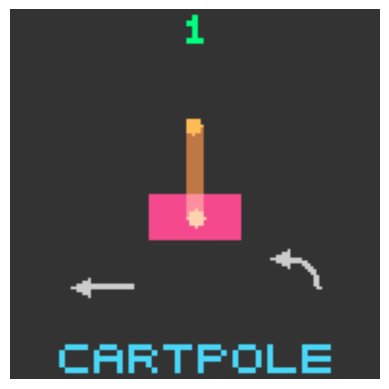

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.06].


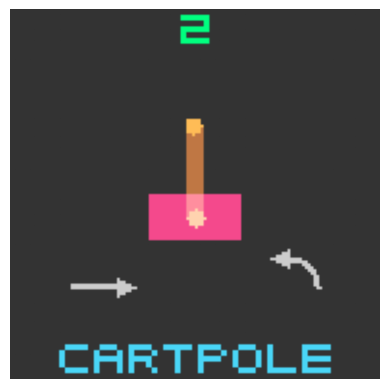

In [1]:
import popgym_arcade
import jax
from matplotlib import pyplot as plt

# Create both POMDP and MDP env variants
pomdp, pomdp_params = popgym_arcade.make("CartPoleEasy", partial_obs=True, obs_size=128)
mdp, mdp_params = popgym_arcade.make("CartPoleEasy", partial_obs=False, obs_size=128)

# Let's vectorize and compile the envs
# Note when you are training a policy, it is better to compile your policy_update rather than the env_step
pomdp_reset = jax.jit(jax.vmap(pomdp.reset, in_axes=(0, None)))
pomdp_step = jax.jit(jax.vmap(pomdp.step, in_axes=(0, 0, 0, None)))
mdp_reset = jax.jit(jax.vmap(mdp.reset, in_axes=(0, None)))
mdp_step = jax.jit(jax.vmap(mdp.step, in_axes=(0, 0, 0, None)))

# Initialize four vectorized environments
n_envs = 4
# Initialize PRNG keys
key = jax.random.key(0)
reset_keys = jax.random.split(key, n_envs)

# Reset environments
observation, env_state = mdp_reset(reset_keys, pomdp_params)

# Step the POMDPs
for t in range(2):
    # Propagate some randomness
    action_key, step_key = jax.random.split(jax.random.key(t))
    action_keys = jax.random.split(action_key, n_envs)
    step_keys = jax.random.split(step_key, n_envs)
    # Pick actions at random
    actions = jax.vmap(pomdp.action_space(pomdp_params).sample)(action_keys)
    # Step the env to the next state
    # No need to reset, gymnax automatically resets when done
    observation, env_state, reward, done, info = mdp_step(step_keys, env_state, actions, pomdp_params)
    plt.axis('off')
    plt.imshow(observation[0])
    plt.show()



# POMDP and MDP variants share states
# We can plug the POMDP states into the MDP and continue playing
action_keys = jax.random.split(jax.random.key(t + 1), n_envs)
step_keys = jax.random.split(jax.random.key(t + 2), n_envs)
markov_state, env_state, reward, done, info = mdp_step(step_keys, env_state, actions, mdp_params)

In [2]:
print(12 * 2 * 3.14 / 360)


0.20933333333333334
